### Import

In [136]:
import os
import re  
import fnmatch 
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_fscore_support

import scipy.stats as stats
from scipy.stats import chi2_contingency

from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MultiLabelBinarizer

### Path

In [2]:
parquet_dir = './Data/parquet/'

### Read Population Labels

In [3]:
pop_labels = pd.read_csv(parquet_dir + 'igsr_samples.tsv', sep='\t')
pop_labels.head(3)

,Sample name,Sex,Biosample ID,Population code,Population name,Superpopulation code,Superpopulation name,Population elastic ID,Data collections
0,HG00271,male,SAME123417,FIN,Finnish,EUR,European Ancestry,FIN,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
1,HG00276,female,SAME123424,FIN,Finnish,EUR,European Ancestry,FIN,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
2,HG00288,female,SAME1839246,FIN,Finnish,EUR,European Ancestry,FIN,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."


### Read Data

In [4]:
df = pd.read_parquet(parquet_dir + "Final_Data.parquet", engine='pyarrow')
result_df = df.transpose()
result_df.head(3)

,rs12124819,rs6681049,rs4970383,rs4475691,rs7537756,rs3748597,rs28391282,rs2340592,rs1891910,rs3128117,...,rs739365,rs5770992,rs2040487,rs9628187,rs6010063,rs10451,rs715586,rs8137951,rs2301584,rs3810648
Person_ID,,,,,,,,,,,,,,,,,,,,,
HG00096,0.0,2.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,2.0,...,0.0,0.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
HG00097,0.0,2.0,1.0,1.0,1.0,2.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HG00099,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


### Preparing Population Codes

In [5]:
pop_labels = pop_labels[pop_labels['Sample name'].isin(result_df.index)]
pop_labels = pop_labels[['Sample name', 'Superpopulation code']]
pop_labels.rename(columns={"Sample name": "Person_ID", "Superpopulation code": "labels"}, inplace=True)
pop_labels.loc[pop_labels.labels == 'EUR,AFR', 'labels'] = 'EUR'
pop_labels.head(3)

,Person_ID,labels
0,HG00271,EUR
1,HG00276,EUR
2,HG00288,EUR


### Principal Component Analysis (PCA)

In [6]:
def apply_pca(train_df, test_df, n_components=None, explained_variance=None):

    if n_components is not None:
        pca = PCA(n_components=n_components, random_state=42)
    elif explained_variance is not None:
        pca = PCA(n_components=explained_variance, random_state=42)
    else:
        pca = PCA(random_state=42)
    
    principal_components_train = pca.fit_transform(train_df)
    principal_components_test = pca.transform(test_df)
    
    col_names = [f'PC{i+1}' for i in range(principal_components_train.shape[1])]
    
    pca_train_df = pd.DataFrame(data=principal_components_train, columns=col_names, index=train_df.index)
    pca_test_df  = pd.DataFrame(data=principal_components_test , columns=col_names, index=test_df.index)
    
    return pca_train_df, pca_test_df

### Singular Value Decomposition (SVD)

In [7]:
def apply_svd_numpy(df, n_components=100):

    centered_data = df - df.mean()
    
    U, s, Vt = np.linalg.svd(centered_data, full_matrices=False)  
    
    U_reduced  = U[:, :n_components]
    s_reduced  = s[:n_components]
    Vt_reduced = Vt[:n_components, :]

    reduced_data = np.dot(U_reduced, np.diag(s_reduced))
    
    col_names = [f'SVD{i+1}' for i in range(n_components)]
    svd_df = pd.DataFrame(data=reduced_data, columns=col_names, index= df.index)
    
    return svd_df

In [8]:
def apply_svd_sklearn(train_df, test_df, n_components=100):

    svd = TruncatedSVD(n_components=n_components, random_state=42)
    
    principal_components_train = svd.fit_transform(train_df)
    principal_components_test  = svd.transform(test_df)
    
    col_names = [f'SVD{i+1}' for i in range(n_components)]
    
    svd_train_df = pd.DataFrame(data=principal_components_train, columns=col_names, index=train_df.index)
    svd_test_df  = pd.DataFrame(data=principal_components_test , columns=col_names, index=test_df.index)
    
    return svd_train_df, svd_test_df

### Random Forest 

In [9]:
def apply_rf_feature_selection(train_df, test_df, labels_df, num_features=None, importance_threshold=None):
    
    merged_df = train_df.merge(labels_df, left_index=True, right_on='Person_ID', how='left')
    
    data = merged_df.drop(columns=['Person_ID', 'labels'])
    labels = merged_df['labels']

    rf = RandomForestClassifier(random_state=42)
    rf.fit(data, labels)

    feature_importances = rf.feature_importances_

    if importance_threshold is not None:
        features_to_keep = train_df.columns[feature_importances >= importance_threshold]
    elif num_features is not None:
        sorted_features = train_df.columns[np.argsort(-feature_importances)]
        features_to_keep = sorted_features[:num_features]
    else:
        features_to_keep = train_df.columns

    rf_train_df = train_df[features_to_keep]
    rf_test_df  = test_df[features_to_keep]
    
    return rf_train_df, rf_test_df

### Normalization

In [10]:
def Normalizing(train_df, test_df):
    
    norm = train_df.columns
    
    train_val = train_df[norm]
    test_val  = test_df[norm]

    scaler = MinMaxScaler().fit(train_val.values)

    train_normalized = scaler.transform(train_val.values)
    test_normalized  = scaler.transform(test_val.values)

    train_df[norm] = train_normalized
    test_df[norm]  = test_normalized

    train_df = train_df.round(3)
    test_df  = test_df.round(3)
    
    return train_df, test_df

### Adding Label

In [11]:
def adding_label(train_df, test_df, labels_df, label_encoder):
    
    train_df = train_df.reset_index()
    test_df  = test_df.reset_index()
    
    train_df = train_df.merge(labels_df, on='Person_ID', how='left')
    test_df  = test_df.merge(labels_df , on='Person_ID', how='left')
    
    train_df['labels'] = label_encoder.transform(train_df['labels'])
    test_df['labels']  = label_encoder.transform(test_df['labels'])
    
    return train_df, test_df

### Apply Model

In [12]:
def apply_model(train_df, test_df):
    
    X_train = train_df.drop(columns=['Person_ID', 'labels'])
    X_test  = test_df.drop(columns=[ 'Person_ID', 'labels'])
    y_train = train_df['labels']
    y_test  = test_df['labels']

    lr_model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs', random_state=42)
    lr_model.fit(X_train, y_train)

    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
    xgb_model.fit(X_train, y_train)

    lr_probabilities  = lr_model.predict_proba(X_test)
    xgb_probabilities = xgb_model.predict_proba(X_test)

    lr_results  = pd.DataFrame(lr_probabilities , columns=[f'LR_Prob_Class_{i}'  for i in range(0, 5)])
    xgb_results = pd.DataFrame(xgb_probabilities, columns=[f'XGB_Prob_Class_{i}' for i in range(0, 5)])

    lr_results['Person_ID']  = test_df['Person_ID'].values
    xgb_results['Person_ID'] = test_df['Person_ID'].values

    lr_results['True_Label'] = y_test.values
    xgb_results['True_Label']= y_test.values

    lr_results  = lr_results[[ 'Person_ID', 'True_Label'] + [f'LR_Prob_Class_{i}'  for i in range(0, 5)]]
    xgb_results = xgb_results[['Person_ID', 'True_Label'] + [f'XGB_Prob_Class_{i}' for i in range(0, 5)]]
    
    return lr_results, xgb_results

### Evaluation

In [112]:
def calculate_predicted_class_lr(df):
    
    predicted_labels = df[['LR_Prob_Class_0', 
                           'LR_Prob_Class_1', 
                           'LR_Prob_Class_2', 
                           'LR_Prob_Class_3', 
                           'LR_Prob_Class_4']].idxmax(axis=1)

    predicted_labels = predicted_labels.apply(lambda x: int(x.split('_')[-1]))
    true_labels = df['True_Label']
    
    return true_labels, predicted_labels

def calculate_predicted_class_xg(df):
    
    predicted_labels = df[['XGB_Prob_Class_0', 
                           'XGB_Prob_Class_1', 
                           'XGB_Prob_Class_2', 
                           'XGB_Prob_Class_3', 
                           'XGB_Prob_Class_4']].idxmax(axis=1)

    predicted_labels = predicted_labels.apply(lambda x: int(x.split('_')[-1]))
    true_labels = df['True_Label']
    
    return true_labels, predicted_labels

In [126]:
def plot_confusion_matrix(true_labels, predicted_labels):
    
    cm = confusion_matrix(true_labels, predicted_labels)

    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['AFR', 'AMR', 'EAS', 'EUR', 'SAS'], 
                                                       yticklabels=['AFR', 'AMR', 'EAS', 'EUR', 'SAS'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

In [114]:
def calculate_performance_metrics(true_labels, predicted_labels):
    
    precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels)
    evaluation_metrics_df = pd.DataFrame({'Class': ['AFR', 'AMR', 'EAS', 'EUR', 'SAS'], 
                                          'Precision': precision,
                                          'Recall': recall,
                                          'F1-Score': f1_score})

    avg_recall = recall.mean()
    avg_precision= precision.mean()
    avg_f1_score = f1_score.mean()
    evaluation_metrics_df = evaluation_metrics_df.append({'Class': 'Average',
                                                          'Precision': avg_precision,
                                                          'Recall': avg_recall,
                                                          'F1-Score': avg_f1_score}, 
                                                          ignore_index=True)

    return evaluation_metrics_df

In [134]:
def plot_roc_curve(true_labels, df, model='LR'):

    y_true = label_binarize(true_labels, classes=[0, 1, 2, 3, 4])
    n_classes = y_true.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    if model == 'LR':
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true[:, i], df[f'LR_Prob_Class_{i}'])
            roc_auc[i] = auc(fpr[i], tpr[i])

        fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), df[['LR_Prob_Class_0', 
                                                                      'LR_Prob_Class_1', 
                                                                      'LR_Prob_Class_2', 
                                                                      'LR_Prob_Class_3', 
                                                                      'LR_Prob_Class_4']].values.ravel())
        
    elif model == 'XGB':
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true[:, i], df[f'XGB_Prob_Class_{i}'])
            roc_auc[i] = auc(fpr[i], tpr[i])

        fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), df[['XGB_Prob_Class_0', 
                                                                      'XGB_Prob_Class_1', 
                                                                      'XGB_Prob_Class_2', 
                                                                      'XGB_Prob_Class_3', 
                                                                      'XGB_Prob_Class_4']].values.ravel())        
        
        
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure(figsize=(8, 6))
    colors = ['blue', 'red', 'green', 'purple', 'orange']

    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.3f})'.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.3f})'.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)


    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of {0} (area = {1:0.3f})'.format(label_encoder.inverse_transform([i])[0], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([-0.01, 1.00])
    plt.ylim([ 0.00, 1.02])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Micro and Macro-Average Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(True, which='both', linestyle='--', linewidth=0.3)
    plt.tight_layout()
    plt.show()

### Cross Validation

In [13]:
number_of_components = 10

In [14]:
label_encoder = LabelEncoder()
label_encoder.fit(['EUR', 'EAS', 'AMR', 'SAS', 'AFR'])

LabelEncoder()

In [ ]:
# {'AFR': 0, 'AMR': 1, 'EAS': 2, 'EUR': 3, 'SAS': 4}

In [15]:
X = pop_labels.drop(['labels'], axis=1)
y = pop_labels['labels']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [16]:
LR_PCA = []
LR_SVD = []
LR_RF  = []

XG_PCA = []
XG_SVD = []
XG_RF  = []

for train_index, test_index in skf.split(X, y):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    
    train_data = result_df[result_df.index.isin(X_train.Person_ID)].copy()
    test_data  = result_df[result_df.index.isin(X_test.Person_ID)].copy()
    
    pca_train_df, pca_test_df = apply_pca(train_data, test_data, n_components=number_of_components, explained_variance=None)  
    svd_train_df, svd_test_df = apply_svd_sklearn(train_data, test_data, n_components=number_of_components)
    rf_train_df , rf_test_df  = apply_rf_feature_selection(train_data, test_data, pop_labels, num_features=number_of_components, importance_threshold=None)
    
    pca_train_df, pca_test_df = Normalizing(pca_train_df, pca_test_df)
    svd_train_df, svd_test_df = Normalizing(svd_train_df, svd_test_df)
    rf_train_df , rf_test_df  = Normalizing(rf_train_df , rf_test_df)
    
    pca_train_df, pca_test_df = adding_label(pca_train_df, pca_test_df, pop_labels, label_encoder)
    svd_train_df, svd_test_df = adding_label(svd_train_df, svd_test_df, pop_labels, label_encoder)
    rf_train_df , rf_test_df  = adding_label(rf_train_df , rf_test_df , pop_labels, label_encoder)
    
    lr_results_pca, xgb_results_pca = apply_model(pca_train_df, pca_test_df)
    lr_results_svd, xgb_results_svd = apply_model(svd_train_df, svd_test_df)
    lr_results_rf , xgb_results_rf  = apply_model(rf_train_df , rf_test_df)
    
    LR_PCA.append(lr_results_pca)
    LR_SVD.append(lr_results_svd)
    LR_RF.append( lr_results_rf)
    
    XG_PCA.append(xgb_results_pca)
    XG_SVD.append(xgb_results_svd)
    XG_RF.append( xgb_results_rf)

/tmp/ipykernel_16478/1217525638.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[norm] = train_normalized
/tmp/ipykernel_16478/1217525638.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[norm]  = test_normalized
/home/behrooz/anaconda3/envs/snp/lib/python3.11/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/behrooz/anaconda3/envs/snp/lib/python3.11/site-packages/xgboos

In [172]:
final_results_LR_PCA = pd.concat(LR_PCA, ignore_index=True)
final_results_LR_SVD = pd.concat(LR_SVD, ignore_index=True)
final_results_LR_RF  = pd.concat(LR_RF , ignore_index=True)

final_results_XG_PCA = pd.concat(XG_PCA, ignore_index=True)
final_results_XG_SVD = pd.concat(XG_SVD, ignore_index=True)
final_results_XG_RF  = pd.concat(XG_RF , ignore_index=True)

In [173]:
labels_LR_PCA, prediction_LR_PCA = calculate_predicted_class_lr(final_results_LR_PCA)
labels_LR_SVD, prediction_LR_SVD = calculate_predicted_class_lr(final_results_LR_SVD)
labels_LR_RF , prediction_LR_RF  = calculate_predicted_class_lr(final_results_LR_RF)

labels_XG_PCA, prediction_XG_PCA = calculate_predicted_class_xg(final_results_XG_PCA)
labels_XG_SVD, prediction_XG_SVD = calculate_predicted_class_xg(final_results_XG_SVD)
labels_XG_RF , prediction_XG_RF  = calculate_predicted_class_xg(final_results_XG_RF)

## LR - PCA

In [174]:
performance_LR_PCA = calculate_performance_metrics(labels_LR_PCA, prediction_LR_PCA)
print(performance_LR_PCA)

     Class  Precision    Recall  F1-Score
0      AFR   0.995461  0.995461  0.995461
1      AMR   0.990798  0.930836  0.959881
2      EAS   1.000000  1.000000  1.000000
3      EUR   0.959924  1.000000  0.979552
4      SAS   1.000000  1.000000  1.000000
5  Average   0.989237  0.985259  0.986979


/tmp/ipykernel_16478/1790184223.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_metrics_df = evaluation_metrics_df.append({'Class': 'Average',


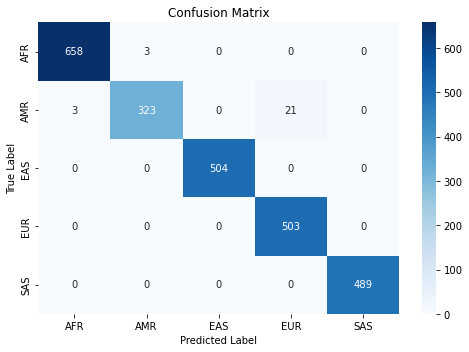

In [175]:
plot_confusion_matrix(labels_LR_PCA, prediction_LR_PCA)

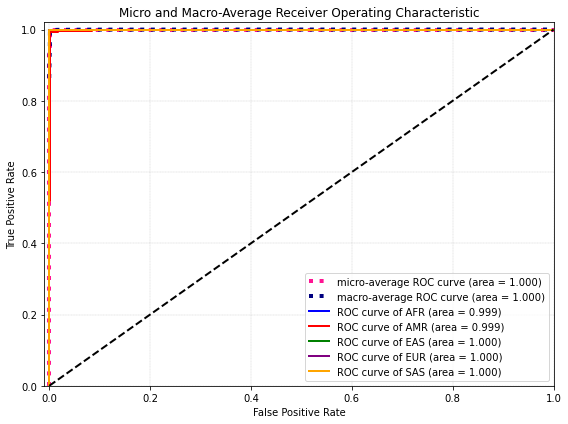

In [176]:
plot_roc_curve(labels_LR_PCA, final_results_LR_PCA, model='LR')

## LR - SVD

In [177]:
performance_LR_SVD = calculate_performance_metrics(labels_LR_SVD, prediction_LR_SVD)
print(performance_LR_SVD)

     Class  Precision    Recall  F1-Score
0      AFR   0.995461  0.995461  0.995461
1      AMR   0.990741  0.925072  0.956781
2      EAS   1.000000  1.000000  1.000000
3      EUR   0.956274  1.000000  0.977648
4      SAS   1.000000  1.000000  1.000000
5  Average   0.988495  0.984107  0.985978


/tmp/ipykernel_16478/1790184223.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_metrics_df = evaluation_metrics_df.append({'Class': 'Average',


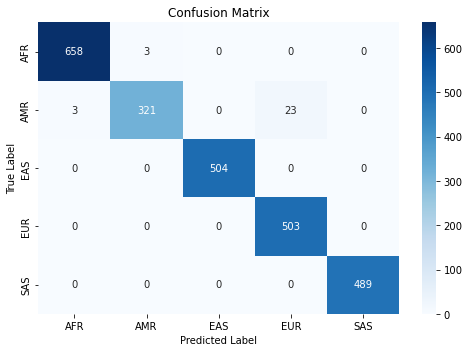

In [178]:
plot_confusion_matrix(labels_LR_SVD, prediction_LR_SVD)

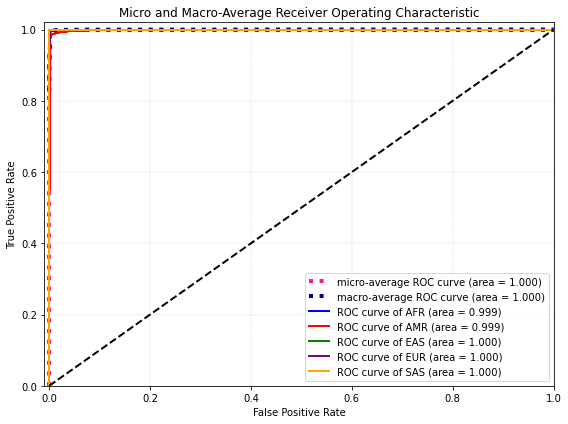

In [179]:
plot_roc_curve(labels_LR_SVD, final_results_LR_SVD, model='LR')

## LR - RF

In [180]:
performance_LR_RF = calculate_performance_metrics(labels_LR_RF , prediction_LR_RF)
print(performance_LR_RF)

     Class  Precision    Recall  F1-Score
0      AFR   0.859397  0.906203  0.882180
1      AMR   0.383838  0.109510  0.170404
2      EAS   0.693443  0.839286  0.759425
3      EUR   0.472546  0.564612  0.514493
4      SAS   0.462777  0.470348  0.466531
5  Average   0.574400  0.577992  0.558607


/tmp/ipykernel_16478/1790184223.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_metrics_df = evaluation_metrics_df.append({'Class': 'Average',


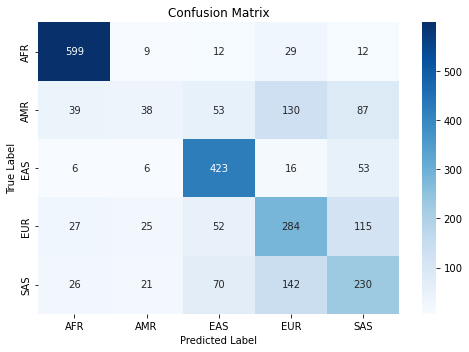

In [181]:
plot_confusion_matrix(labels_LR_RF , prediction_LR_RF)

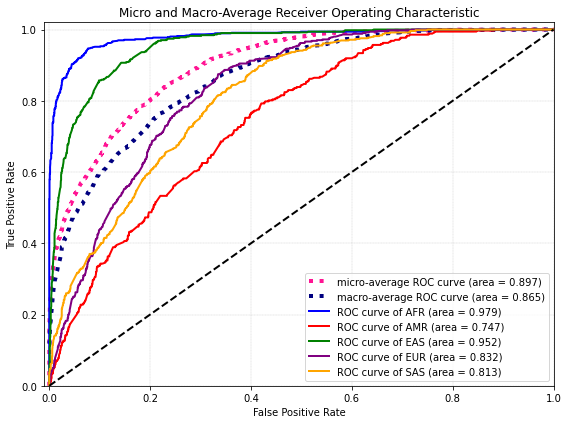

In [182]:
plot_roc_curve(labels_LR_RF, final_results_LR_RF, model='LR')

## XGB - PCA

In [183]:
performance_XG_PCA = calculate_performance_metrics(labels_XG_PCA, prediction_XG_PCA)
print(performance_XG_PCA)

     Class  Precision    Recall  F1-Score
0      AFR   0.993939  0.992436  0.993187
1      AMR   0.985549  0.982709  0.984127
2      EAS   1.000000  1.000000  1.000000
3      EUR   0.994048  0.996024  0.995035
4      SAS   0.997959  1.000000  0.998979
5  Average   0.994299  0.994234  0.994265


/tmp/ipykernel_16478/1790184223.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_metrics_df = evaluation_metrics_df.append({'Class': 'Average',


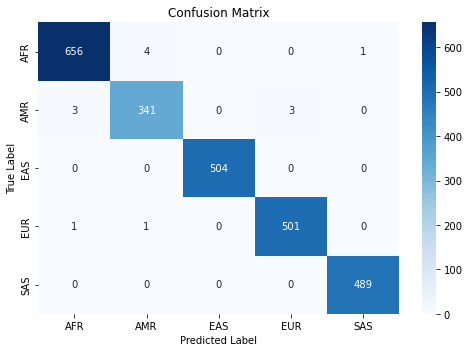

In [184]:
plot_confusion_matrix(labels_XG_PCA, prediction_XG_PCA)

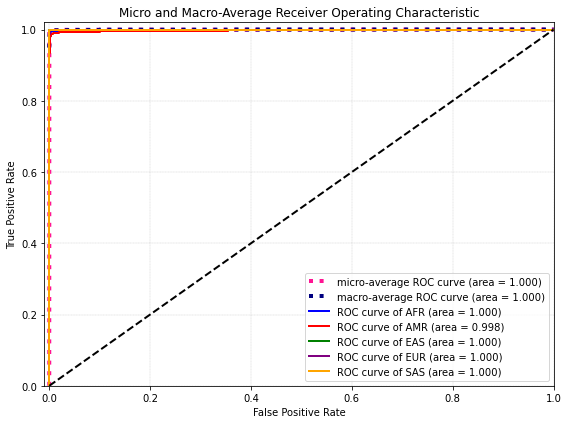

In [185]:
plot_roc_curve(labels_XG_PCA, final_results_XG_PCA, model='XGB')

## XGB - SVD 

In [186]:
performance_XG_SVD = calculate_performance_metrics(labels_XG_SVD, prediction_XG_SVD)
print(performance_XG_SVD)

     Class  Precision    Recall  F1-Score
0      AFR   0.995448  0.992436  0.993939
1      AMR   0.985549  0.982709  0.984127
2      EAS   0.996047  1.000000  0.998020
3      EUR   0.994036  0.994036  0.994036
4      SAS   0.997959  1.000000  0.998979
5  Average   0.993808  0.993836  0.993820


/tmp/ipykernel_16478/1790184223.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_metrics_df = evaluation_metrics_df.append({'Class': 'Average',


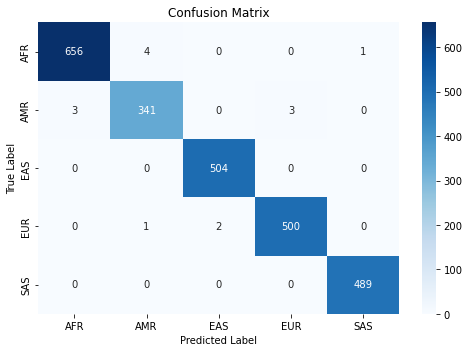

In [187]:
plot_confusion_matrix(labels_XG_SVD, prediction_XG_SVD)

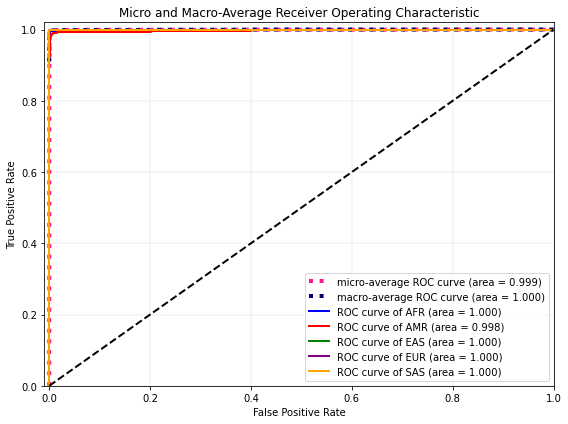

In [188]:
plot_roc_curve(labels_XG_SVD, final_results_XG_SVD, model='XGB')

## XFB - RF

In [189]:
performance_XG_RF = calculate_performance_metrics(labels_XG_RF , prediction_XG_RF)
print(performance_XG_RF)

     Class  Precision    Recall  F1-Score
0      AFR   0.870482  0.874433  0.872453
1      AMR   0.242009  0.152738  0.187279
2      EAS   0.698795  0.805556  0.748387
3      EUR   0.460630  0.465209  0.462908
4      SAS   0.443609  0.482618  0.462292
5  Average   0.543105  0.556110  0.546664


/tmp/ipykernel_16478/1790184223.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  evaluation_metrics_df = evaluation_metrics_df.append({'Class': 'Average',


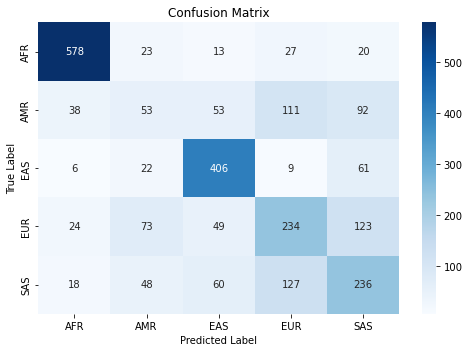

In [190]:
plot_confusion_matrix(labels_XG_RF , prediction_XG_RF)

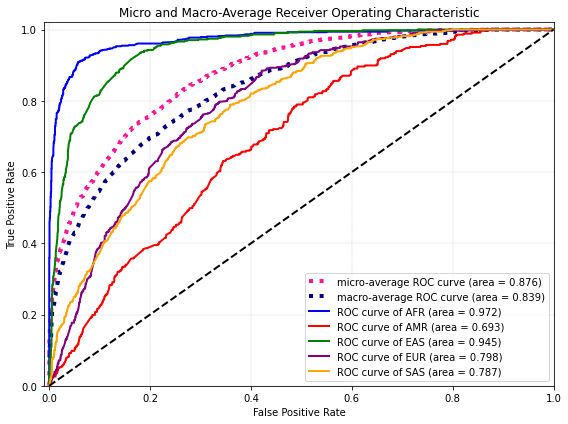

In [191]:
plot_roc_curve(labels_XG_RF, final_results_XG_RF, model='XGB')